# Setup

First, let's make sure this notebook works well in both python 2 and 3, import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures:

In [1]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "end_to_end_project"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

# Get the data

In [2]:
import os
import tarfile
from six.moves import urllib

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    os.makedirs(housing_path, exist_ok=True)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [3]:
fetch_housing_data()

In [4]:
import pandas as pd
pd.set_option('display.max_rows', 500)

#def load_housing_data(housing_path=HOUSING_PATH):
#    csv_path = os.path.join(housing_path, "housing.csv")
#    return pd.read_csv(csv_path)

DATASET_PATH = "datasets/uci/"
def load_uci_data(path):
    csv_path = os.path.join(DATASET_PATH, path)
    return pd.read_csv(csv_path)

In [5]:
#housing = load_housing_data()
#housing.head()

#Otros candidatos a agregar:

# Producto 11: Incidencia por region
# https://github.com/MinCiencia/Datos-COVID19/tree/master/output/producto11

# Producto 26: Casos nuevos con sintomas por region
# https://github.com/MinCiencia/Datos-COVID19/tree/master/output/producto26

# Producto 27: Casos nuevos sin sintomas por region
# https://github.com/MinCiencia/Datos-COVID19/tree/master/output/producto27

# Producto 38: Casos fallecidos por comuna (usar CasosFallecidosPorComuna_std)
# https://github.com/MinCiencia/Datos-COVID19/tree/master/output/producto38

# -------------------------------------------------------------------------------

# Producto 8: Pacientes COVID UCI (RM)
# https://github.com/MinCiencia/Datos-COVID19/tree/master/output/producto8
uci_region = load_uci_data("UCI_T.csv")

# Producto 19: Casos activos (RM)
# https://github.com/MinCiencia/Datos-COVID19/tree/master/output/producto19
casos_activos = load_uci_data("ActivosComuna_std.csv") #Nuevo

# Producto 20: Número de ventiladores
# https://github.com/MinCiencia/Datos-COVID19/tree/master/output/producto20
vent_disp = load_uci_data("NumeroVentiladores_T.csv")

# Producto 23: Pacientes críticos
# https://github.com/MinCiencia/Datos-COVID19/tree/master/output/producto23
uci_covid_nacional = load_uci_data("PacientesCriticos_T.csv")

# Producto 24: Camas Hospital Diario
# https://github.com/MinCiencia/Datos-COVID19/tree/master/output/producto24
camas = load_uci_data("CamasHospital_Diario_T.csv")

# Producto 35: Comorbilidad
# https://github.com/MinCiencia/Datos-COVID19/tree/master/output/producto35
comorb_nacional = load_uci_data("Comorbilidad_T.csv")

# Producto 37: Defunciones
# https://github.com/MinCiencia/Datos-COVID19/tree/master/output/producto37
defunc_nacional = load_uci_data("Defunciones_T.csv")

# Productos 38: Casos fallecidos por comuna
#https://github.com/MinCiencia/Datos-COVID19/tree/master/output/producto38
defunc_regional = load_uci_data("CasosFallecidosComuna_std.csv")   

# Producto 44: Evolución semanal de egresos hospitalarios pacientes COVID-19
# https://github.com/MinCiencia/Datos-COVID19/tree/master/output/producto44
egresos_nacional = load_uci_data("Egresos_std.csv") #Nuevo

# Producto 52: Camas Hospital (RM)
# https://github.com/MinCiencia/Datos-COVID19/tree/master/output/producto52
camas_region = load_uci_data("CamasHospital_Regional_std.csv")

# Producto 74: Paso a paso
# https://github.com/MinCiencia/Datos-COVID19/tree/master/output/producto74
paso_a_paso = load_uci_data("paso_a_paso_T.csv")

# Producto 76: Avance en Campaña de Vacunación COVID-19
# https://github.com/MinCiencia/Datos-COVID19/tree/master/output/producto76
Vacunacion = pd.read_csv(os.path.join("datasets/uci/", "vacunacion_t.txt"), sep=",", header=None)

## Limpieza de datos

In [6]:
comorb_nacional.columns

Index(['Comorbilidad', 'Hipertensión arterial', 'Diabetes', 'Obesidad', 'Asma',
       'Enfermedad cardiovascular', 'Enfermedad pulmonar crónica',
       'Cardiopatía crónica', 'Enfermedad renal crónica',
       'Enfermedad neurológica crónica', 'Inmunocomprometido',
       'Enfermedad hepática crónica', 'Hipertensión arterial.1', 'Diabetes.1',
       'Obesidad.1', 'Asma.1', 'Enfermedad cardiovascular.1',
       'Enfermedad pulmonar crónica.1', 'Cardiopatía crónica.1',
       'Enfermedad renal crónica.1', 'Enfermedad neurológica crónica.1',
       'Inmunocomprometido.1', 'Enfermedad hepática crónica.1'],
      dtype='object')

In [7]:
from statistics import mode

camas_region = camas_region[camas_region["Region"].str.match("Metropolitana")]
camas_region = camas_region.groupby(["Fecha", "Serie"])["Fecha", "Serie", "Casos"].sum().reset_index()
camas_region = camas_region.pivot_table(index=['Fecha'], columns=['Serie'], values='Casos').fillna(0)
#camas_region.set_index(camas_region["Fecha"], inplace=True)
#camas_region.drop(axis=1, labels="Fecha", inplace=True)
camas_region.drop(axis=1, labels="Camas base (2019)", inplace=True)

camas_region.index.name=None

#Tenemos tambien las camas nacionales, pero es preferible usar las regionales
camas.columns = ['Fecha', 'Camas basicas nac.', 'Camas medias nac.', 'Camas UTI nac.', 'Camas UCI nac.']
camas.set_index(camas["Fecha"], drop=True, inplace=True)
camas.drop(axis=1, labels=["Fecha"], inplace=True)
camas.index.name = None


comorb_nacional.drop(comorb_nacional.columns[[*range(1,12)]], axis=1, inplace=True)
comorb_nacional.columns = ['Comorbilidad', 'Hipertensión arterial', 'Diabetes', 'Obesidad', 'Asma',
       'Enfermedad cardiovascular', 'Enfermedad pulmonar crónica',
       'Cardiopatía crónica', 'Enfermedad renal crónica',
       'Enfermedad neurológica crónica', 'Inmunocomprometido',
       'Enfermedad hepática crónica']
comorb_nacional.drop([0],axis=0, inplace=True)
comorb_nacional.set_index(comorb_nacional["Comorbilidad"], drop=True, inplace=True)
comorb_nacional.drop(axis=1, labels=["Comorbilidad"], inplace=True)
comorb_nacional.index.name = None

defunc_nacional = defunc_nacional[["Fecha","Defunciones_2020-07-16"]]
defunc_nacional.columns = ["Fecha", "Defunciones nacional"]
defunc_nacional.set_index(defunc_nacional["Fecha"], inplace=True)
defunc_nacional.drop(axis=1, labels="Fecha", inplace=True)
defunc_nacional.index.name = None

defunc_regional = defunc_regional[4:]
defunc_regional.set_index(defunc_regional["Region"], inplace=True)
defunc_regional = defunc_regional.iloc[:,95:148]
defunc_regional = defunc_regional.apply(pd.to_numeric)
defunc_regional["Defunciones regional"] = defunc_regional.sum(axis=1,numeric_only=True)
defunc_regional.index.name = None
defunc_regional = defunc_regional["Defunciones regional"]

vent_disp.columns = ["Fecha", "Total vent.", "Vent. ocupados", "Vent. disponibles"]
vent_disp.set_index(vent_disp["Fecha"], inplace=True)
vent_disp.drop(axis=1, labels="Fecha", inplace=True)
vent_disp.index.name = None

uci_covid_nacional.columns = ["Fecha", "Pac. criticos nacional"]
uci_covid_nacional.set_index(uci_covid_nacional["Fecha"], inplace=True)
uci_covid_nacional.drop(axis=1, labels="Fecha", inplace=True)
uci_covid_nacional.index.name = None

uci_region = uci_region[["Region", "Metropolitana"]]
uci_region.columns = ["Fecha", "Casos diarios region"]
uci_region.drop([0,1],axis=0, inplace=True)
uci_region.set_index(uci_region["Fecha"], inplace=True)
uci_region.drop(axis=1, labels="Fecha", inplace=True)
uci_region.index.name = None

#casos_activos = casos_activos.rename(columns = {'Casos activos':'Casos activos region'})
casos_activos = casos_activos.loc[:,["Region", "Fecha", "Casos activos"]]
casos_activos.columns = ["Region", "Fecha", "Casos activos region"]
casos_activos = casos_activos[casos_activos["Region"].str.match("Metropolitana")]
casos_activos = casos_activos.groupby("Fecha")["Fecha", "Casos activos region"].sum().reset_index()
casos_activos.set_index(casos_activos["Fecha"], inplace=True)
casos_activos.drop(axis=1, labels="Fecha", inplace=True)
casos_activos.index.name=None

paso_a_paso = paso_a_paso.iloc[4:,:]
paso_a_paso.set_index(paso_a_paso["codigo_region"], drop=True, inplace=True)
paso_a_paso.drop(axis=1, labels=["codigo_region"], inplace=True)
paso_a_paso.index.name = None
moda = [mode(paso_a_paso.iloc[i,:]) for i in range(paso_a_paso.shape[0])]
moda = np.asarray(moda)
paso_a_paso["Paso a paso"] = moda
paso_a_paso = pd.to_numeric(paso_a_paso.iloc[:,-1], downcast='float')

# Este requiere tratamiento
#egresos_nacional = egresos_nacional[["Fecha Publicación", "Egresos"]]
#egresos_nacional.set_index(egresos_nacional["Fecha Publicación"],inplace=True)
#egresos_nacional.drop(axis=1, labels="Fecha Publicación", inplace=True)
#egresos_nacional.index.name = None



#camas.set_index(camas["Tipo de cama"], drop=True)
#amas.drop(axis=1, labels=["Tipo de cama"])

#amas.set_index(camas["Tipo de cama"], drop=True)
#amas.drop(axis=1, labels=["Tipo de cama"])

<ipython-input-7-8babb83c1e7e>:4: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  camas_region = camas_region.groupby(["Fecha", "Serie"])["Fecha", "Serie", "Casos"].sum().reset_index()
<ipython-input-7-8babb83c1e7e>:65: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  casos_activos = casos_activos.groupby("Fecha")["Fecha", "Casos activos region"].sum().reset_index()


In [8]:
# Ajuste de datos de vacunacion
Vacunacion = Vacunacion[[0, 1, 2, 3]]
Vacunacion.columns = ["Fecha", "Primera_V", "Segunda_V", "V_Unica"]
Vacunacion = Vacunacion.drop([0,1])
Vacunacion.set_index("Fecha", drop=True, inplace=True)

i=0
anterior = 0
tmp_list = []
while(i < len(Vacunacion)):
    tmp_list.append(int(float(Vacunacion["Primera_V"][i])) - anterior)
    anterior = int(float(Vacunacion["Primera_V"][i]))
    i=i+1

Vacunacion["Primera_V_Daily"] = tmp_list

i=0
anterior = 0
tmp_list = []
while(i < len(Vacunacion)):
    tmp_list.append(int(float(Vacunacion["Segunda_V"][i])) - anterior)
    anterior = int(float(Vacunacion["Segunda_V"][i]))
    i=i+1
    
Vacunacion["Segunda_V_Daily"] = tmp_list

i=0
anterior = 0
tmp_list = []
while(i < len(Vacunacion)):
    tmp_list.append(int(float(Vacunacion["V_Unica"][i])) - anterior)
    anterior = int(float(Vacunacion["V_Unica"][i]))
    i=i+1
    
Vacunacion["V_Unica_Daily"] = tmp_list
Vacunacion = Vacunacion[["Primera_V_Daily", "Segunda_V_Daily", "V_Unica_Daily"]]
Vacunacion.columns = ["Primera_V", "Segunda_V", "V_Unica"]

In [9]:
comorb_nacional.columns

Index(['Hipertensión arterial', 'Diabetes', 'Obesidad', 'Asma',
       'Enfermedad cardiovascular', 'Enfermedad pulmonar crónica',
       'Cardiopatía crónica', 'Enfermedad renal crónica',
       'Enfermedad neurológica crónica', 'Inmunocomprometido',
       'Enfermedad hepática crónica'],
      dtype='object')

In [10]:
data = pd.merge(camas, comorb_nacional, how='outer',left_index=True, right_index=True)
data = pd.merge(data, camas_region, how='outer', left_index=True, right_index=True)
data = pd.merge(data, defunc_nacional,how='outer',left_index=True, right_index=True)
data = pd.merge(data, defunc_regional,how='outer',left_index=True, right_index=True)
data = pd.merge(data, vent_disp,how='outer', left_index=True, right_index=True)
data = pd.merge(data, uci_covid_nacional,how='outer', left_index=True, right_index=True)
data = pd.merge(data, uci_region,how='outer', left_index=True, right_index=True)
data = pd.merge(data, casos_activos,how='outer', left_index=True, right_index=True)
data = pd.merge(data, paso_a_paso,how='outer', left_index=True, right_index=True)
data = pd.merge(data, Vacunacion,how='outer', left_index=True, right_index=True)

data = data.loc['2020-04-14':]
data.index = pd.to_datetime(data.index)
for col in data:
    data[col] = pd.to_numeric(data[col], errors='coerce')

In [11]:
#tmp_data = data[["Primera_V", "Segunda_V", "V_Unica"]].loc[data["Primera_V"].isnull()].replace(to_replace = np.nan, value = 0, inplace = True)
#tmp_data.append(data[["Primera_V", "Segunda_V", "V_Unica"]].loc[not data["Primera_V"].isnull()])
#data

#data[["Primera_V", "Segunda_V", "V_Unica"]][~data["Primera_V"].isnull()]
i=0
while(i < len(data)):
    if(data[["Primera_V"]].isnull().iloc[i,0]):
        data["Primera_V"][i] = 0
        data["Segunda_V"][i] = 0
        data["V_Unica"][i] = 0
    i = i+1


<ipython-input-11-9862db73691e>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Primera_V"][i] = 0
<ipython-input-11-9862db73691e>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Segunda_V"][i] = 0
<ipython-input-11-9862db73691e>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["V_Unica"][i] = 0


In [12]:
#uci_region
# VER UMBRAL y proporción de NaNs
#data.columns
data_rows = data.shape[0]
nan_proportions = data.apply(lambda x: x.isnull().sum() / data_rows, axis=0).to_frame()
#nan_proportions
data_non_imputable = nan_proportions.loc[nan_proportions[0] >= 0.15]
data_non_imputable
#type(nan_proportions)

#data1.apply(lambda x: x.interpolate())

# Hacer



,0
Hipertensión arterial,0.767010
Diabetes,0.767010
Obesidad,0.767010
Asma,0.767010
Enfermedad cardiovascular,0.767010
Enfermedad pulmonar crónica,0.767010
Cardiopatía crónica,0.767010
Enfermedad renal crónica,0.767010
Enfermedad neurológica crónica,0.767010
Inmunocomprometido,0.767010


In [13]:
def inputData(colname, df):
    colname=colname + " interp"
    df = df.assign(colname=df.interpolate(method='spline', order=3))
    return df

In [14]:
inputable = nan_proportions.loc[nan_proportions[0] <= 0.15]
inputable

,0
Camas basicas nac.,0.090722
Camas medias nac.,0.090722
Camas UTI nac.,0.090722
Camas UCI nac.,0.090722
Camas UCI habilitadas,0.088660
Camas UCI ocupadas COVID-19,0.088660
Camas UCI ocupadas no COVID-19,0.088660
Total vent.,0.086598
Vent. ocupados,0.086598
Vent. disponibles,0.086598


In [15]:
#data = data.assign(Hipertensión_arterial_interp=data["Hipertensión arterial"].interpolate(method='spline', order=3, inplace=True))

#Columnas con <15% casos faltantes
data["Camas basicas nac."].interpolate(method='spline', order=2, inplace=True)
data["Camas medias nac."].interpolate(method='spline', order=2, inplace=True)
data["Camas UTI nac."].interpolate(method='spline', order=2, inplace=True)
data["Camas UCI nac."].interpolate(method='spline', order=2, inplace=True)
data["Camas UCI habilitadas"].interpolate(method='spline', order=2, inplace=True)
data["Camas UCI ocupadas COVID-19"].interpolate(method='spline', order=2, inplace=True)
data["Camas UCI ocupadas no COVID-19"].interpolate(method='spline', order=2, inplace=True)

#Columnas con >15% casos faltantes
data["Pac. criticos nacional"].rolling(24, min_periods=1,).median()
data["Hipertensión arterial"].interpolate(method='linear', inplace=True)
data["Diabetes"].interpolate(method='linear', inplace=True)
data["Obesidad"].interpolate(method='linear', inplace=True)
data["Asma"].interpolate(method='linear', inplace=True)
data["Enfermedad cardiovascular"].interpolate(method='linear', inplace=True)
data["Enfermedad pulmonar crónica"].interpolate(method='linear', inplace=True)
data["Cardiopatía crónica"].interpolate(method='linear', inplace=True)
data["Enfermedad renal crónica"].interpolate(method='linear', inplace=True)
data["Enfermedad neurológica crónica"].interpolate(method='linear', inplace=True)
data["Inmunocomprometido"].interpolate(method='linear', inplace=True)
data["Enfermedad hepática crónica"].interpolate(method='linear', inplace=True)
data["Defunciones nacional"].rolling(24, min_periods=1,).median()
data["Defunciones regional"].interpolate(method='linear', inplace=True)
data["Casos activos region"].interpolate(method='spline', order=3, inplace=True)

data["Paso a paso"].interpolate(method='backfill',inplace=True)

#data["Pac. criticos nacional"].interpolate(method='time', inplace=True)
#data["Hipertensión arterial"].interpolate(method='time', inplace=True)
#data["Diabetes"].interpolate(method='time', inplace=True)
#data["Obesidad"].interpolate(method='time', inplace=True)
#data["Asma"].interpolate(method='time', inplace=True)
#data["Enfermedad cardiovascular"].interpolate(method='time', inplace=True)
#data["Enfermedad pulmonar crónica"].interpolate(method='time', inplace=True)
#data["Cardiopatía crónica"].interpolate(method='time', inplace=True)
#data["Enfermedad renal crónica"].interpolate(method='time', inplace=True)
#data["Enfermedad neurológica crónica"].interpolate(method='time', inplace=True)
#data["Inmunocomprometido"].interpolate(method='time', inplace=True)
#data["Enfermedad hepática crónica"].interpolate(method='time', inplace=True)
#data["Defunciones nacional"].interpolate(method='time', inplace=True)
#data["Casos activos region"].interpolate(method='time', inplace=True)

#for col in list(inputable.index):
#    print(col)
#    data = inputData(col, data)

In [16]:
data.apply(lambda x: x.isnull().sum() / data_rows, axis=0).to_frame()

,0
Camas basicas nac.,0.004124
Camas medias nac.,0.004124
Camas UTI nac.,0.004124
Camas UCI nac.,0.004124
Hipertensión arterial,0.084536
Diabetes,0.084536
Obesidad,0.084536
Asma,0.084536
Enfermedad cardiovascular,0.084536
Enfermedad pulmonar crónica,0.084536


In [17]:
data.isnull().sum(axis=1)

2020-04-14    17
2020-04-15    16
2020-04-16    12
2020-04-17    12
2020-04-18    12
2020-04-19    12
2020-04-20    12
2020-04-21    12
2020-04-22    12
2020-04-23    12
2020-04-24    12
2020-04-25    12
2020-04-26    12
2020-04-27    12
2020-04-28    12
2020-04-29    12
2020-04-30    12
2020-05-01    12
2020-05-02    12
2020-05-03    12
2020-05-04    12
2020-05-05    12
2020-05-06    12
2020-05-07    12
2020-05-08    12
2020-05-09    12
2020-05-10    12
2020-05-11    12
2020-05-12    12
2020-05-13    12
2020-05-14    12
2020-05-15    12
2020-05-16    12
2020-05-17    12
2020-05-18    12
2020-05-19    12
2020-05-20    12
2020-05-21    12
2020-05-22    12
2020-05-23    12
2020-05-24    12
2020-05-25     1
2020-05-26     1
2020-05-27     1
2020-05-28     1
2020-05-29     1
2020-05-30     1
2020-05-31     1
2020-06-01     1
2020-06-02     1
2020-06-03     1
2020-06-04     1
2020-06-05     1
2020-06-06     1
2020-06-07     1
2020-06-08     1
2020-06-09     1
2020-06-10     1
2020-06-11    

In [18]:
data = data.loc['2020-06-12':'2021-06-30']

In [19]:
data.isnull().sum(axis=1)

2020-06-12    0
2020-06-13    0
2020-06-14    0
2020-06-15    0
2020-06-16    0
2020-06-17    0
2020-06-18    0
2020-06-19    0
2020-06-20    0
2020-06-21    0
2020-06-22    0
2020-06-23    0
2020-06-24    0
2020-06-25    0
2020-06-26    0
2020-06-27    0
2020-06-28    0
2020-06-29    0
2020-06-30    0
2020-07-01    0
2020-07-02    0
2020-07-03    0
2020-07-04    0
2020-07-05    0
2020-07-06    0
2020-07-07    0
2020-07-08    0
2020-07-09    0
2020-07-10    0
2020-07-11    0
2020-07-12    0
2020-07-13    0
2020-07-14    0
2020-07-15    1
2020-07-16    1
2020-07-17    1
2020-07-18    1
2020-07-19    1
2020-07-20    1
2020-07-21    1
2020-07-22    1
2020-07-23    1
2020-07-24    1
2020-07-25    1
2020-07-26    1
2020-07-27    1
2020-07-28    1
2020-07-29    1
2020-07-30    1
2020-07-31    1
2020-08-01    1
2020-08-02    1
2020-08-03    1
2020-08-04    1
2020-08-05    1
2020-08-06    1
2020-08-07    1
2020-08-08    1
2020-08-09    1
2020-08-10    1
2020-08-11    1
2020-08-12    1
2020-08-

## Visualización de los datos

In [20]:
%matplotlib inline
import matplotlib.pyplot as plt
#plt.rcParams['figure.dpi'] = 100
plt.rcParams['figure.figsize'] = [15, 10]

Text(0, 0.5, 'Cantidad de vacunados')

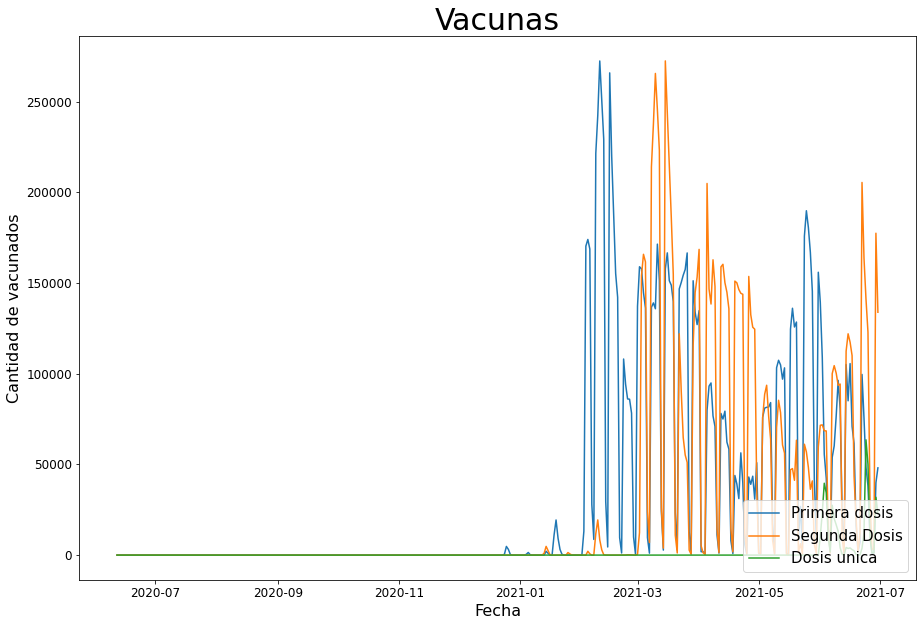

In [21]:
fig, ax1 = plt.subplots(1, 1)
ax1.plot(data.iloc[:,[27, 28, 29]])
ax1.legend(('Primera dosis', 'Segunda Dosis', 'Dosis unica'), fontsize=15 , loc=4)
plt.title("Vacunas", fontsize=30)
plt.xlabel("Fecha", fontsize=16)
plt.ylabel("Cantidad de vacunados", fontsize=16)

Text(0, 0.5, 'Cantidad camas')

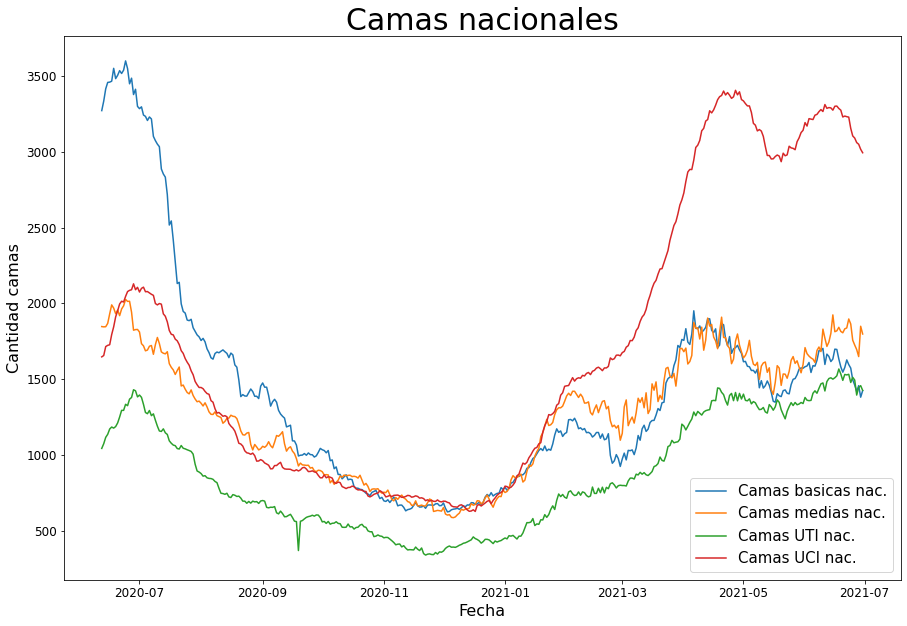

In [22]:
fig, ax1 = plt.subplots(1, 1)
ax1.plot(data.iloc[:,[0,1,2,3]])
ax1.legend(('Camas basicas nac.', 'Camas medias nac.', 'Camas UTI nac.',
       'Camas UCI nac.'), fontsize=15 , loc=4)
plt.title("Camas nacionales", fontsize=30)
plt.xlabel("Fecha", fontsize=16)
plt.ylabel("Cantidad camas", fontsize=16)

Text(0, 0.5, 'Cantidad camas')

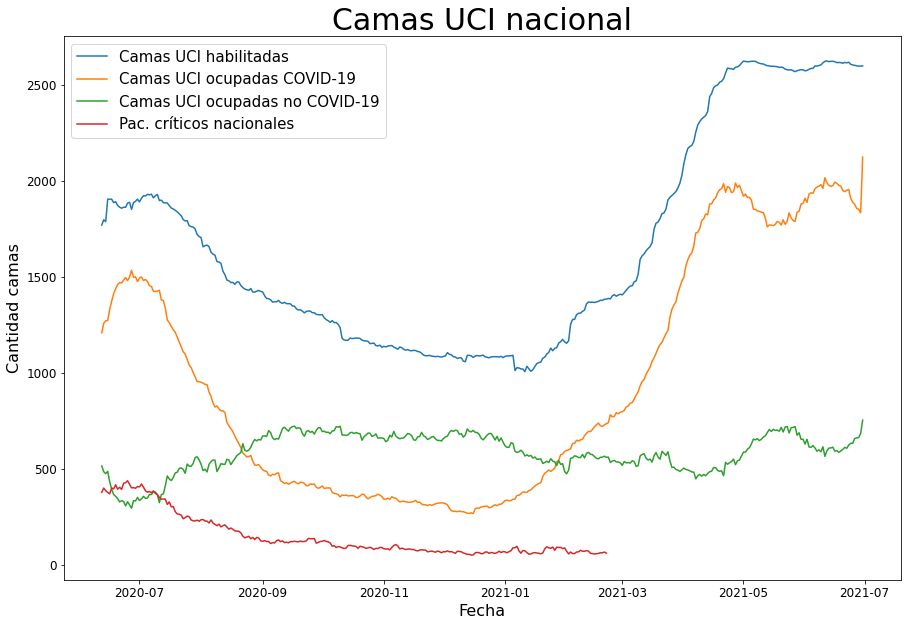

In [23]:
fig, ax2 = plt.subplots(1, 1)
ax2.plot(data.iloc[:,[15,16,17,23]])
ax2.legend(('Camas UCI habilitadas',
       'Camas UCI ocupadas COVID-19', 'Camas UCI ocupadas no COVID-19', 'Pac. críticos nacionales'), fontsize=15)
plt.title("Camas UCI nacional", fontsize=30)
plt.xlabel("Fecha", fontsize=16)
plt.ylabel("Cantidad camas", fontsize=16)

Text(0, 0.5, 'Personas con comorbilidad')

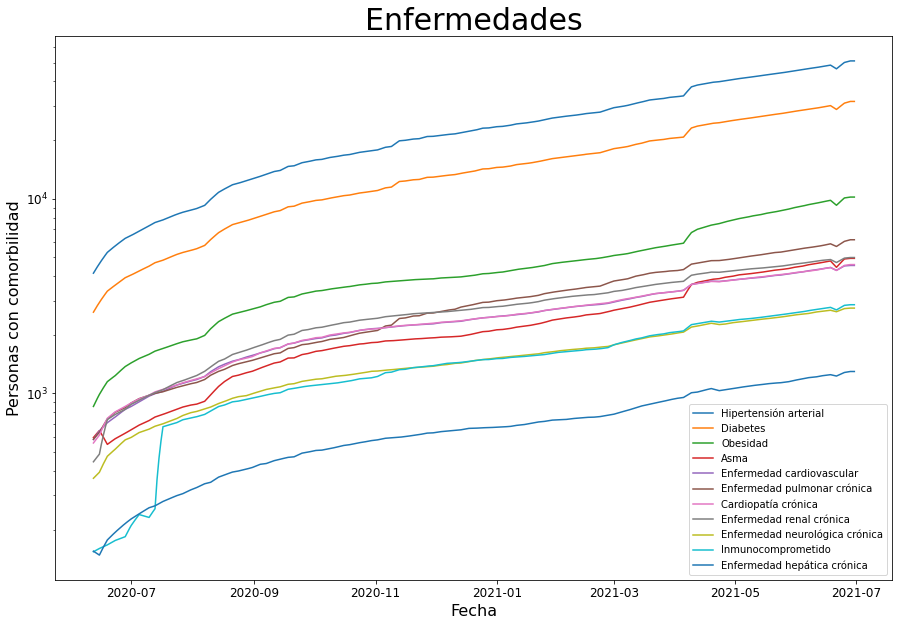

In [24]:
fig, ax3 = plt.subplots(1, 1)
ax3.plot(data.iloc[:,[4,5,6,7,8,9,10,11,12,13,14]])
ax3.legend(('Hipertensión arterial', 'Diabetes', 'Obesidad',
       'Asma', 'Enfermedad cardiovascular', 'Enfermedad pulmonar crónica',
       'Cardiopatía crónica', 'Enfermedad renal crónica',
       'Enfermedad neurológica crónica','Inmunocomprometido',
       'Enfermedad hepática crónica'))
plt.yscale('log')
plt.title("Enfermedades", fontsize=30)
plt.xlabel("Fecha", fontsize=16)
plt.ylabel("Personas con comorbilidad", fontsize=16)

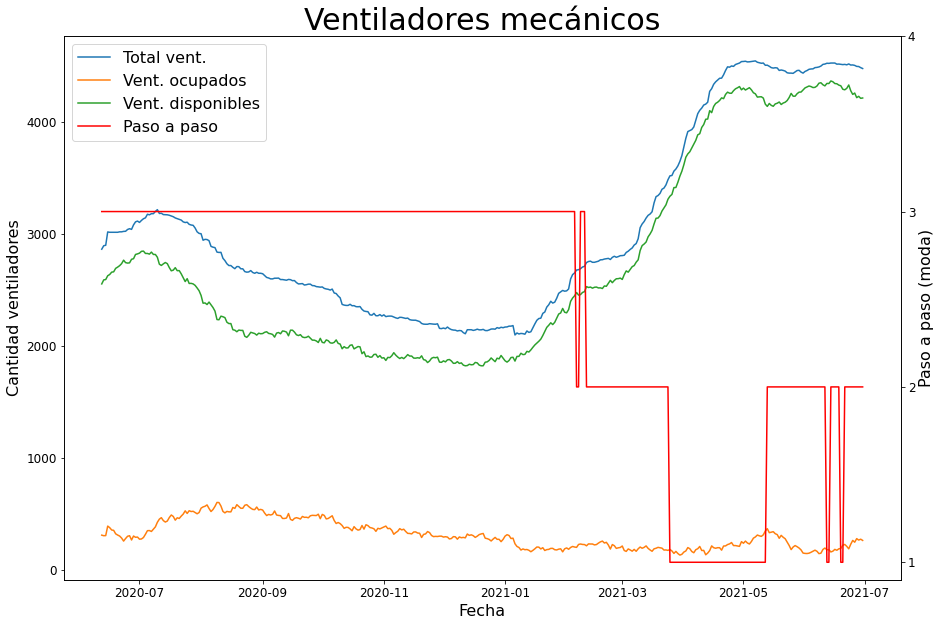

In [25]:
fig, ax4 = plt.subplots(1, 1)
ventiladores_plot = ax4.plot(data.iloc[:,[20,21,22]])
#ax4.legend(('Total vent.', 'Vent. ocupados',
       #'Vent. disponibles'), fontsize=15)
plt.title("Ventiladores mecánicos", fontsize=30)
plt.xlabel("Fecha", fontsize=16)
plt.ylabel("Cantidad ventiladores", fontsize=16)
ax5 = ax4.twinx()
pasos_plot = ax5.plot(data.iloc[:,26], color="red")
ax5.set_yticks([1, 2, 3, 4])
plt.ylabel("Paso a paso (moda)", fontsize=16)
#ax5.set_ytickslabels(("Paso 1", "Paso 2", "Paso 3", "Paso 4"))
plot = ventiladores_plot + pasos_plot
ax4.legend(plot, ["Total vent.", "Vent. ocupados", "Vent. disponibles", "Paso a paso"], fontsize=16)

Text(0, 0.5, 'Casos activos')

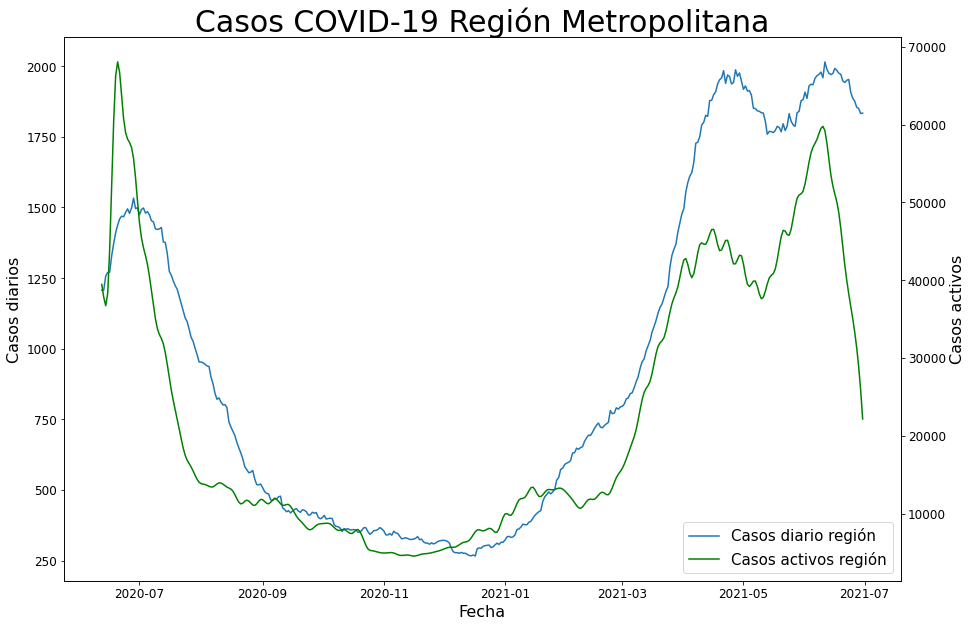

In [26]:
fig, ax5 = plt.subplots(1, 1)
diarios_plot = ax5.plot(data.iloc[:,24])
plt.title("Casos COVID-19 Región Metropolitana", fontsize=30)
plt.xlabel("Fecha", fontsize=16)
plt.ylabel("Casos diarios", fontsize=16)
ax6 = ax5.twinx()
activos_plot = ax6.plot(data.iloc[:,25], color="green")
plot = diarios_plot + activos_plot
ax5.legend(plot, ["Casos diario región", "Casos activos región"], fontsize=15, loc=4)
plt.ylabel("Casos activos", fontsize=16)

Text(0, 0.5, 'Cantidad ventiladores')

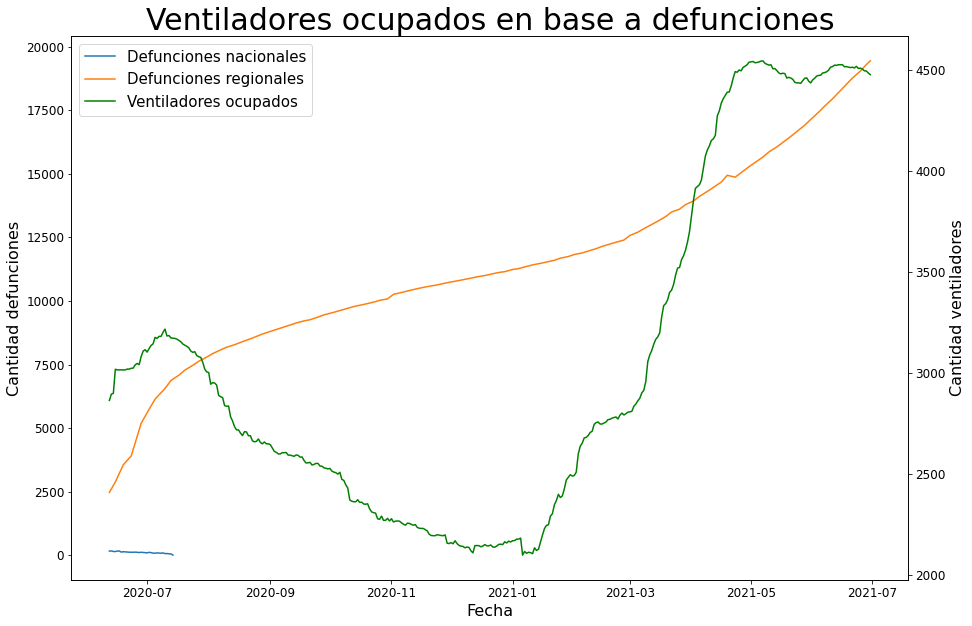

In [27]:
fig, ax7 = plt.subplots(1, 1)
defunciones_plot = ax7.plot(data.iloc[:,[18,19]])
#ax7.legend(('Defunciones', 'Vent. ocupados'), fontsize=15)
plt.title("Ventiladores ocupados en base a defunciones", fontsize=30)
plt.xlabel("Fecha", fontsize=16)
plt.ylabel("Cantidad defunciones", fontsize=16)
ax8 = ax7.twinx()
ventiladores_plot = ax8.plot(data.iloc[:,20], color="green")
plot = defunciones_plot + ventiladores_plot
ax8.legend(plot, ["Defunciones nacionales", "Defunciones regionales", "Ventiladores ocupados"], fontsize=15)
plt.ylabel("Cantidad ventiladores", fontsize=16)

## Limpieza de variables
### Se eliminan variables con datos faltantes incluso después de la interpolación.
Candidatos: 
 - Pacientes críticos
 - Defunciones nacional 

In [28]:
data = data.drop(labels=["Pac. criticos nacional", "Defunciones nacional"], axis=1)

Revisando que no queden datos faltantes

In [29]:
data.isnull().sum(axis=1)

2020-06-12    0
2020-06-13    0
2020-06-14    0
2020-06-15    0
2020-06-16    0
2020-06-17    0
2020-06-18    0
2020-06-19    0
2020-06-20    0
2020-06-21    0
2020-06-22    0
2020-06-23    0
2020-06-24    0
2020-06-25    0
2020-06-26    0
2020-06-27    0
2020-06-28    0
2020-06-29    0
2020-06-30    0
2020-07-01    0
2020-07-02    0
2020-07-03    0
2020-07-04    0
2020-07-05    0
2020-07-06    0
2020-07-07    0
2020-07-08    0
2020-07-09    0
2020-07-10    0
2020-07-11    0
2020-07-12    0
2020-07-13    0
2020-07-14    0
2020-07-15    0
2020-07-16    0
2020-07-17    0
2020-07-18    0
2020-07-19    0
2020-07-20    0
2020-07-21    0
2020-07-22    0
2020-07-23    0
2020-07-24    0
2020-07-25    0
2020-07-26    0
2020-07-27    0
2020-07-28    0
2020-07-29    0
2020-07-30    0
2020-07-31    0
2020-08-01    0
2020-08-02    0
2020-08-03    0
2020-08-04    0
2020-08-05    0
2020-08-06    0
2020-08-07    0
2020-08-08    0
2020-08-09    0
2020-08-10    0
2020-08-11    0
2020-08-12    0
2020-08-

## Visualización y análisis de correlación

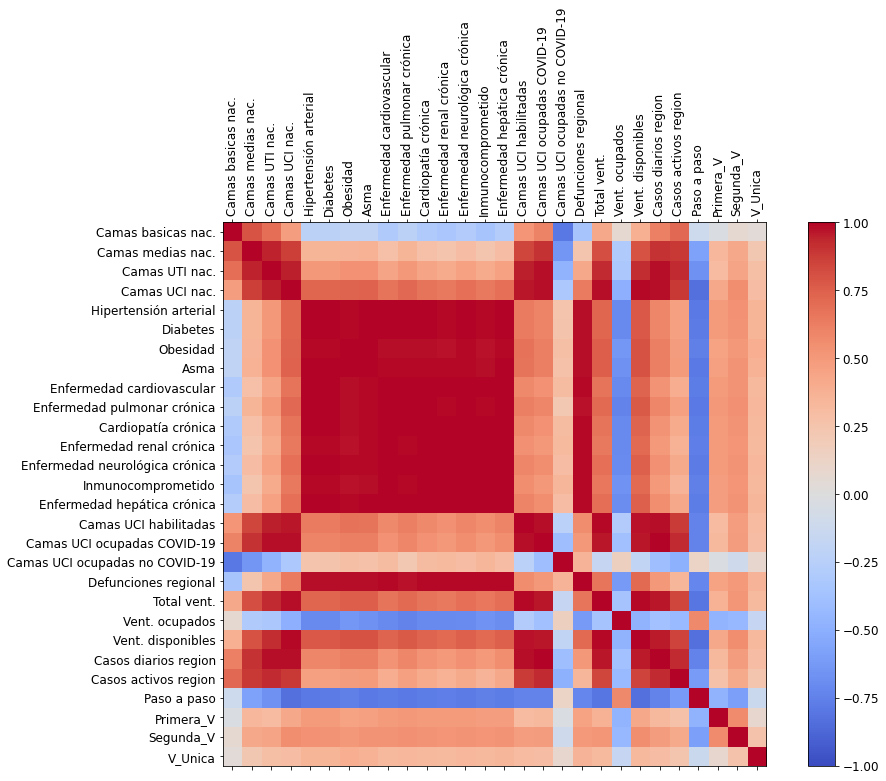

In [30]:
corr = data.corr(method="pearson")
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(corr,cmap='coolwarm', vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,len(data.columns),1)
ax.set_xticks(ticks)
plt.xticks(rotation=90)
ax.set_yticks(ticks)
ax.set_xticklabels(data.columns)
ax.set_yticklabels(data.columns)
plt.show()

In [31]:
corr

,Camas basicas nac.,Camas medias nac.,Camas UTI nac.,Camas UCI nac.,Hipertensión arterial,Diabetes,Obesidad,Asma,Enfermedad cardiovascular,Enfermedad pulmonar crónica,...,Defunciones regional,Total vent.,Vent. ocupados,Vent. disponibles,Casos diarios region,Casos activos region,Paso a paso,Primera_V,Segunda_V,V_Unica
Camas basicas nac.,1.000000,0.794989,0.691557,0.473381,-0.224191,-0.223546,-0.201194,-0.202001,-0.300963,-0.220249,...,-0.344792,0.415443,0.061681,0.382552,0.610986,0.712323,-0.112038,-0.025949,0.067824,0.037738
Camas medias nac.,0.794989,1.000000,0.944689,0.864451,0.346805,0.347294,0.358681,0.364988,0.277774,0.351502,...,0.235527,0.807464,-0.302399,0.802827,0.902638,0.884021,-0.582756,0.334687,0.419179,0.220081
Camas UTI nac.,0.691557,0.944689,1.000000,0.948444,0.507118,0.507799,0.535813,0.532821,0.438682,0.501793,...,0.414629,0.927399,-0.324469,0.918865,0.982511,0.925610,-0.668621,0.307477,0.443427,0.285960
Camas UCI nac.,0.473381,0.864451,0.948444,1.000000,0.722160,0.722135,0.733443,0.739929,0.669690,0.718561,...,0.637939,0.976976,-0.492257,0.989109,0.978411,0.885783,-0.834249,0.414260,0.549237,0.290420
Hipertensión arterial,-0.224191,0.346805,0.507118,0.722160,1.000000,0.999986,0.991389,0.996639,0.995674,0.997801,...,0.980785,0.721630,-0.704845,0.778505,0.593025,0.464626,-0.782878,0.485971,0.532652,0.346728
Diabetes,-0.223546,0.347294,0.507799,0.722135,0.999986,1.000000,0.991880,0.996820,0.995482,0.997624,...,0.980932,0.722067,-0.703572,0.778738,0.593348,0.465068,-0.781020,0.485314,0.530829,0.348273
Obesidad,-0.201194,0.358681,0.535813,0.733443,0.991389,0.991880,1.000000,0.997323,0.983399,0.981698,...,0.979335,0.753303,-0.637573,0.798885,0.618613,0.483347,-0.752885,0.446677,0.505629,0.386069
Asma,-0.202001,0.364988,0.532821,0.739929,0.996639,0.996820,0.997323,1.000000,0.990460,0.989542,...,0.977633,0.750855,-0.666967,0.800708,0.618156,0.485928,-0.783140,0.468255,0.526830,0.360075
Enfermedad cardiovascular,-0.300963,0.277774,0.438682,0.669690,0.995674,0.995482,0.983399,0.990460,1.000000,0.993713,...,0.986601,0.670252,-0.704160,0.730028,0.528850,0.397792,-0.769887,0.485744,0.525501,0.326338
Enfermedad pulmonar crónica,-0.220249,0.351502,0.501793,0.718561,0.997801,0.997624,0.981698,0.989542,0.993713,1.000000,...,0.975332,0.706779,-0.736822,0.769010,0.585831,0.462737,-0.787736,0.505514,0.542071,0.335825


## Preparación de los datos

### Pacientes críticos acumulados a diarios

In [32]:
defunc_ix = list(data.columns).index("Defunciones regional")

In [33]:
from sklearn.preprocessing import MinMaxScaler
X = data.copy()
scaler = MinMaxScaler(feature_range=(0, 1))
X = scaler.fit_transform(X)
X = pd.DataFrame(X, columns=data.columns, index=data.index)

ind = int(X.shape[0]*0.7)
ind_name = data.index[ind]
ind_name_nxt = data.index[ind+1]
#y_index = list(data.columns).index("Camas UCI ocupadas COVID-19")

y_lab = "Camas UCI nac."

X_train = X.loc[:ind_name, X.columns != y_lab]
X_test = X.loc[ind_name_nxt:, X.columns != y_lab]
y_train = X.loc[:ind_name, "Camas UCI nac."]
y_test = X.loc[ind_name_nxt:, "Camas UCI nac."]

In [34]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import FunctionTransformer
#from sklearn.preprocessing import StandardScaler

#defunc_ix, bedrooms_ix, population_ix, household_ix = [
#    list(housing.columns).index(col)
#    for col in ("total_rooms", "total_bedrooms", "population", "households")]
defunc_ix = list(X_train.columns).index("Defunciones regional")
# = data.iloc[:, defunc_ix]
class DataFormatter(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): # no *args or **kwargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self  # nothing else to do
    def acum_to_daily(self, X, y=None):
        temp_defunc = X[:, defunc_ix]
        defunc_diario = [temp_defunc[i] - temp_defunc[i-1] for i in range(X.shape[0]-1,0,-1)]
        defunc_diario = np.flip(defunc_diario).tolist()
        defunc_diario[0] = 0
        defunc_diario.append(temp_defunc[X.shape[0]-1])
        X[:,defunc_ix] = defunc_diario
        return X
        #return np.c_[X, defunc_diario]
    def scale_data(self, X, y=None):
        scaler = MinMaxScaler(feature_range=(0, 1))
        data_scaled = scaler.fit_transform(X)
        return data_scaled

formatter = DataFormatter()


In [35]:
data_prec_train = formatter.acum_to_daily(X_train.values)
data_prec_test = formatter.acum_to_daily(X_test.values)

In [36]:
#data_prec_train_norm = formatter.scale_data(data_prec_train)
#data_prec_test_norm = formatter.scale_data(data_prec_test)

In [37]:
x_train = pd.DataFrame(
    data=data_prec_train,
    columns=list(X_train.columns),
    index=X_train.index)

x_test = pd.DataFrame(
    data=data_prec_test,
    columns=list(X_test.columns),
    index=X_test.index)

In [38]:
x_train.shape

(269, 27)

In [39]:
y_train.shape

(269,)

## Eliminación de variables por importancia

In [40]:
from xgboost import XGBClassifier

model = XGBClassifier()
model.fit(X_train, y_train)
importances = pd.DataFrame(data={
    'Attribute': X_train.columns,
    'Importance': model.feature_importances_
})
importances = importances.sort_values(by='Importance', ascending=False)
importances

C:\ProgramData\Miniconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:14:38] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


,Attribute,Importance
6,Asma,0.262527
21,Casos diarios region,0.062741
22,Casos activos region,0.059602
15,Camas UCI ocupadas COVID-19,0.058344
0,Camas basicas nac.,0.058067
1,Camas medias nac.,0.055422
16,Camas UCI ocupadas no COVID-19,0.053891
18,Total vent.,0.053862
3,Hipertensión arterial,0.051383
2,Camas UTI nac.,0.050893


In [41]:
x_train2 = x_train.drop(["Diabetes", "Obesidad", "Enfermedad cardiovascular","Enfermedad hepática crónica", "Enfermedad pulmonar crónica", "Cardiopatía crónica", "Enfermedad renal crónica", "Inmunocomprometido", "Enfermedad neurológica crónica","Paso a paso", "V_Unica", "Segunda_V"], axis=1)
x_test2 = x_test.drop(["Diabetes", "Obesidad", "Enfermedad cardiovascular","Enfermedad hepática crónica", "Enfermedad pulmonar crónica", "Cardiopatía crónica", "Enfermedad renal crónica", "Inmunocomprometido", "Enfermedad neurológica crónica","Paso a paso", "V_Unica", "Segunda_V"], axis=1)

In [42]:
model.fit(x_train2, y_train)
importances = pd.DataFrame(data={
    'Attribute': x_train2.columns,
    'Importance': model.feature_importances_
})
importances = importances.sort_values(by='Importance', ascending=False)
importances

C:\ProgramData\Miniconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:14:41] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


,Attribute,Importance
4,Asma,0.263956
12,Casos diarios region,0.063201
13,Casos activos region,0.059926
6,Camas UCI ocupadas COVID-19,0.058894
0,Camas basicas nac.,0.057868
1,Camas medias nac.,0.055721
9,Total vent.,0.054245
7,Camas UCI ocupadas no COVID-19,0.054121
3,Hipertensión arterial,0.051663
2,Camas UTI nac.,0.051099


In [43]:
# Hacer plot de importancia

## Eliminar variables correlacionadas

In [44]:
corr = x_train2.corr(method="pearson")
corr

,Camas basicas nac.,Camas medias nac.,Camas UTI nac.,Hipertensión arterial,Asma,Camas UCI habilitadas,Camas UCI ocupadas COVID-19,Camas UCI ocupadas no COVID-19,Defunciones regional,Total vent.,Vent. ocupados,Vent. disponibles,Casos diarios region,Casos activos region,Primera_V
Camas basicas nac.,1.000000,0.912555,0.938480,-0.748079,-0.783352,0.917544,0.947316,-0.862420,0.031063,0.825606,0.181586,0.806740,0.944366,0.936553,-0.086456
Camas medias nac.,0.912555,1.000000,0.958650,-0.521098,-0.555985,0.883072,0.940987,-0.897748,0.067066,0.892982,0.044567,0.930066,0.938467,0.858551,0.167446
Camas UTI nac.,0.938480,0.958650,1.000000,-0.603769,-0.641186,0.941061,0.980419,-0.901898,0.086499,0.925497,0.113761,0.938348,0.980517,0.880278,0.079262
Hipertensión arterial,-0.748079,-0.521098,-0.603769,1.000000,0.993382,-0.761066,-0.617452,0.417413,0.070619,-0.611303,-0.711411,-0.378885,-0.622346,-0.576572,0.436371
Asma,-0.783352,-0.555985,-0.641186,0.993382,1.000000,-0.786253,-0.661240,0.480238,0.067413,-0.631390,-0.670836,-0.415548,-0.666231,-0.618850,0.431123
Camas UCI habilitadas,0.917544,0.883072,0.941061,-0.761066,-0.786253,1.000000,0.949125,-0.780109,0.073584,0.963001,0.381766,0.876645,0.952376,0.792866,-0.002594
Camas UCI ocupadas COVID-19,0.947316,0.940987,0.980419,-0.617452,-0.661240,0.949125,1.000000,-0.924593,0.091076,0.913960,0.099350,0.931570,0.999350,0.890389,0.064089
Camas UCI ocupadas no COVID-19,-0.862420,-0.897748,-0.901898,0.417413,0.480238,-0.780109,-0.924593,1.000000,-0.077783,-0.758394,0.129546,-0.853268,-0.921649,-0.862527,-0.084098
Defunciones regional,0.031063,0.067066,0.086499,0.070619,0.067413,0.073584,0.091076,-0.077783,1.000000,0.101492,-0.088133,0.140993,0.089786,0.081489,-0.022888
Total vent.,0.825606,0.892982,0.925497,-0.611303,-0.631390,0.963001,0.913960,-0.758394,0.101492,1.000000,0.333568,0.934129,0.918941,0.695690,0.152251


In [45]:

cor_matrix = corr.abs()
upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(np.bool))
#upper_tri.iloc[4,:] > 0.90
#print(upper_tri)
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.90)]
print(to_drop)

#data_dropped = x_train.copy()
#data_dropped = data_dropped.drop(to_drop, axis=1)

['Camas medias nac.', 'Camas UTI nac.', 'Asma', 'Camas UCI habilitadas', 'Camas UCI ocupadas COVID-19', 'Camas UCI ocupadas no COVID-19', 'Total vent.', 'Vent. disponibles', 'Casos diarios region', 'Casos activos region']


<ipython-input-45-e18e441e33a4>:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(np.bool))


In [46]:
x_train3 = x_train2.drop(["Hipertensión arterial", "Camas UTI nac.", "Camas UCI ocupadas COVID-19", "Camas UCI habilitadas", 'Camas medias nac.', 'Vent. disponibles', 'Casos activos region'], axis=1)
x_test3 = x_test2.drop(["Hipertensión arterial", "Camas UTI nac.", "Camas UCI ocupadas COVID-19", "Camas UCI habilitadas", 'Camas medias nac.', 'Vent. disponibles', 'Casos activos region'], axis=1)
corr = x_train3.corr(method="pearson")
corr
#to_drop = x_train[["Enfermedad renal crónica", "Camas UCI nac.", ]]

,Camas basicas nac.,Asma,Camas UCI ocupadas no COVID-19,Defunciones regional,Total vent.,Vent. ocupados,Casos diarios region,Primera_V
Camas basicas nac.,1.000000,-0.783352,-0.862420,0.031063,0.825606,0.181586,0.944366,-0.086456
Asma,-0.783352,1.000000,0.480238,0.067413,-0.631390,-0.670836,-0.666231,0.431123
Camas UCI ocupadas no COVID-19,-0.862420,0.480238,1.000000,-0.077783,-0.758394,0.129546,-0.921649,-0.084098
Defunciones regional,0.031063,0.067413,-0.077783,1.000000,0.101492,-0.088133,0.089786,-0.022888
Total vent.,0.825606,-0.631390,-0.758394,0.101492,1.000000,0.333568,0.918941,0.152251
Vent. ocupados,0.181586,-0.670836,0.129546,-0.088133,0.333568,1.000000,0.112883,-0.352940
Casos diarios region,0.944366,-0.666231,-0.921649,0.089786,0.918941,0.112883,1.000000,0.061290
Primera_V,-0.086456,0.431123,-0.084098,-0.022888,0.152251,-0.352940,0.061290,1.000000


In [47]:
model.fit(x_train3, y_train)
importances = pd.DataFrame(data={
    'Attribute': x_train3.columns,
    'Importance': model.feature_importances_
})
importances = importances.sort_values(by='Importance', ascending=False)
importances

C:\ProgramData\Miniconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:14:45] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


,Attribute,Importance
6,Casos diarios region,0.151559
0,Camas basicas nac.,0.134127
4,Total vent.,0.130004
2,Camas UCI ocupadas no COVID-19,0.125385
3,Defunciones regional,0.118569
1,Asma,0.114198
7,Primera_V,0.114011
5,Vent. ocupados,0.112147


In [48]:
x_train = x_train3.copy()
x_test = x_test3.copy()

In [49]:
x_train = pd.merge(x_train, y_train, how='outer',left_index=True, right_index=True)
x_test = pd.merge(x_test, y_test, how='outer',left_index=True, right_index=True)

- To do: sintonización de selección de variables

# Modelación

In [50]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
from sklearn.metrics import mean_squared_error        
from sklearn.metrics import mean_absolute_error
from copy import deepcopy

In [51]:
#from sklearn.model_selection import TimeSeriesSplit

#test_size = round(0.25*data.shape[0])
#print(test_size)
#data_x = data.drop("Camas UCI ocupadas COVID-19", axis=1)
#data_y = data["Camas UCI ocupadas COVID-19"].copy()
#split = TimeSeriesSplit(data_x, data_y, test_size=test_size)
#for train_index, test_index in TimeSeriesSplit.split(data_x):
#    print("TRAIN:", train_index, "TEST:", test_index)
#    X_train, X_test = X[train_index], X[test_index]
#    y_train, y_test = y[train_index], y[test_index]

In [52]:
#data = strat_train_set.drop("Camas UCI ocupadas COVID-19", axis=1)
#uci = strat_train_set["Camas UCI ocupadas COVID-19"].copy()

In [53]:
x_train_temp = deepcopy(x_train)
x_test_temp = deepcopy(x_test)
y_train_temp = deepcopy(y_train)
y_test_temp = deepcopy(y_test)

### Función de retrasos

In [54]:
# Function to create the data set
# Equation f(yt) = f(yt-1)
# convert an array of values into a dataset matrix
def create_dataset(name, dataset, look_back=1):
    dataX, dataY = [], []
    names = [(name + "_t-" + str(i)) for i in range(look_back)]
    names.reverse()
    dt = dataset.values
    for i in range(len(dt)-look_back-1):
        a = dt[i:(i+look_back)]
        dataX.append(a)
        dataY.append(dt[i + look_back])
    indices = dataset.index[(look_back+1):]
    dataset_ret = pd.DataFrame(dataX, columns=names, index=indices)
    return dataset_ret#np.array(dataX), np.array(dataY)

In [55]:
# Insertar retardos en dataset
def insert_lags(data, lags):
    dt = pd.DataFrame()
    for col in data.columns:
        var = data[col]
        var_ret = create_dataset(col, var, lags)
        selected_cols = var_ret.columns[:-1] # Remove Xt-0
        var_ret = var_ret[selected_cols]
        dt[selected_cols] = var_ret
    dataframe = pd.DataFrame(dt)
    return dataframe

In [56]:
def lags_preparation(x_train,x_test,y_train,y_test, lags):
    
    # Insertar retardos en variables x
    x_train = insert_lags(x_train, lags)
    x_test = insert_lags(x_test, lags)
    
    # Insertar retardos en variables y
    y_lab = y_test.name
    y_lab_t0 = y_lab + "_t-0"
    y_train = create_dataset(y_lab, y_train, lags)
    y_train = y_train[[y_lab_t0]]
    y_test = create_dataset(y_lab, y_test, lags)
    y_test = y_test[[y_lab_t0]]
    return(x_train, x_test, y_train, y_test)

In [57]:
#x_train = insert_lags(x_train, look_back)
#x_test = insert_lags(x_test, look_back)

In [58]:
# Insertar retardos en variables y
#y_lab_t0 = y_lab + "_t-0"

#y_train = create_dataset(y_lab, y_train, look_back)
#y_train = y_train[[y_lab_t0]]
#y_test = create_dataset(y_lab, y_test, look_back)
#y_test = y_test[[y_lab_t0]]

In [59]:
# Insertar retardos en dataset de features test
#dt_test = pd.DataFrame()
#for col in x_test.columns:
#    var = x_test[col]
#    var_ret = create_dataset(col, var, look_back)
#    selected_cols = var_ret.columns[:-1] # Remove Xt-0
#    var_ret = var_ret[selected_cols]
#    dt_test[selected_cols] = var_ret
#x_test = pd.DataFrame(dt_test)

In [60]:
x_train_temp = x_train
x_test_temp = x_test

y_train_temp = y_train
y_test_temp = y_test

## Modelo de regresión lineal

In [61]:
#import sys
#!{sys.executable} -m pip install sklearn

In [62]:
look_back = 2 # Esto se debe cambiar al hacer tuning

In [63]:
train_x, test_x, train_y, test_y = lags_preparation(x_train, x_test, y_train, y_test, look_back)

In [64]:
from sklearn.linear_model import LinearRegression


lin_reg = LinearRegression()
lin_reg.fit(train_x, train_y)

LinearRegression()

In [65]:
linear_predct = lin_reg.predict(test_x)
linear_predct = linear_predct[:,0]
print("Predictions:", linear_predct)

Predictions: [0.43400972 0.44174932 0.4510331  0.46279046 0.46777466 0.48126627
 0.50266176 0.51406425 0.53161897 0.54000216 0.54778809 0.56219389
 0.57495062 0.57325966 0.58668121 0.60393993 0.61573984 0.64150791
 0.66129273 0.68190555 0.69002516 0.70809757 0.72936523 0.7411648
 0.75735142 0.78504333 0.80112375 0.80717153 0.81347723 0.83538198
 0.8616315  0.8698772  0.87738013 0.9001046  0.90585505 0.92490067
 0.92640367 0.9455972  0.93721388 0.94582405 0.95761625 0.96675827
 0.97164541 0.97884272 0.98795689 0.97415513 0.98201695 0.97664603
 0.97002652 0.97374625 0.98980661 0.98175582 0.98618089 0.96630036
 0.96365163 0.95597313 0.95167716 0.95153594 0.93483624 0.91126423
 0.90773543 0.89416987 0.89683055 0.893781   0.88040298 0.85710787
 0.8398101  0.83981109 0.83340133 0.82939391 0.8368349  0.83989282
 0.84163512 0.82609588 0.8459924  0.83945926 0.8414705  0.86312649
 0.86380951 0.86040544 0.85785532 0.88095008 0.887259   0.90089158
 0.9070651  0.92573182 0.91815806 0.93707797 0.934

In [66]:
linear_predct = pd.Series(linear_predct)
linear_predct.index = test_x.index

#print(y_test)
#print(linear_predct.index)

data_linear = pd.concat([test_y, linear_predct], axis=1)

lin_corr = test_y.iloc[:,0].corr(linear_predct)
lin_corr

0.9972709802148088

In [67]:
from sklearn.metrics import mean_squared_error

lin_mse = mean_squared_error(test_y, linear_predct)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

0.013446583714680497

In [68]:
from sklearn.metrics import mean_absolute_error

lin_mae = mean_absolute_error(test_y, linear_predct)
lin_mae

0.011118677248331602

Text(0, 0.5, 'UCI ocupadas')

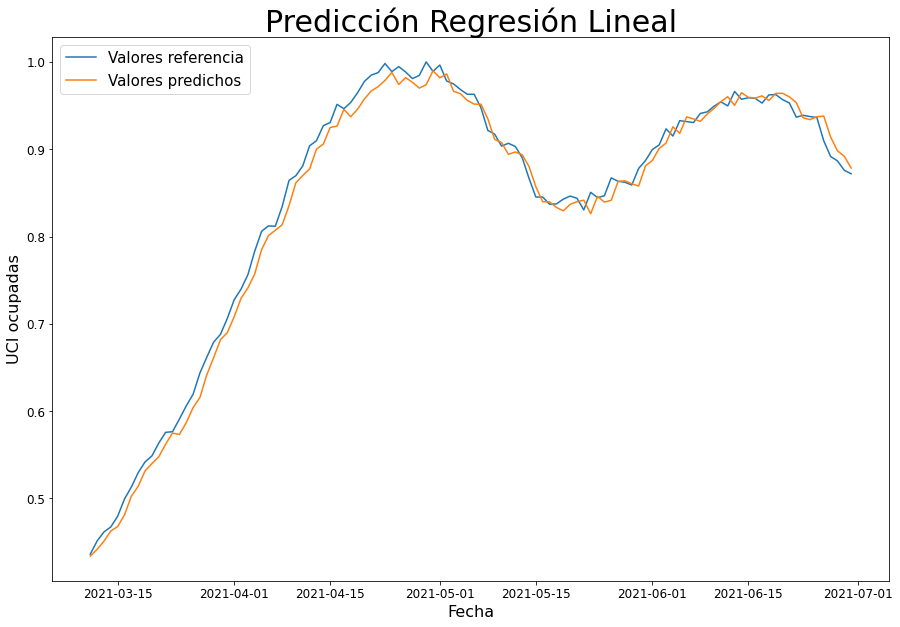

In [69]:
fig, ax4 = plt.subplots(1, 1)
ax4.plot(data_linear)
ax4.legend(('Valores referencia', 'Valores predichos'), fontsize=15)
plt.title("Predicción Regresión Lineal", fontsize=30)
plt.xlabel("Fecha", fontsize=16)
plt.ylabel("UCI ocupadas", fontsize=16)

## Multilayer Perceptron model

### Parameter Tuning

In [70]:
def tune_multilayer_NN(x_train, x_test, y_train, y_test,lags=[2,3,4],
                       layer1=[4,5,6], layer2=[2,3,4],layer3=None, 
                       epochs=50, activation=['relu'], optimizer=['adam'], batches=2, verbose=True):
    a = [lags, layer1, layer2, activation, optimizer]
    comb_n = len(list(itertools.product(*a)))
    performances = np.zeros((comb_n,5))
    combinations = np.empty((comb_n,6), dtype='<U32')
    i = 0
    np.seterr(divide='ignore', invalid='ignore')
    for comb in itertools.product(*a):
        lag = comb[0]
        layer1 = comb[1]
        layer2 = comb[2]
        activation = comb[3]
        optimizer = comb[4]
        combinations[i, :] = np.array([i, lag, layer1, layer2, activation, optimizer])
        if verbose:
            print("Testing combination " + str(i) + ": " + str(comb))
        else:
            print("Progress: " + str(i) + "/" + str(comb_n))
        # Add lags in dataset
        train_x, test_x, train_y, test_y = lags_preparation(x_train, x_test, y_train, y_test, lag)
        
        # Create and fit Multilayer Perceptron model
        model = Sequential()
        model.add(Dense(layer1, input_dim=train_x.shape[1], activation=activation))
        model.add(Dense(layer2, activation=activation))
        model.add(Dense(1))
        model.compile(loss='mean_squared_error', optimizer=optimizer)
        model.fit(train_x, train_y, shuffle=False, epochs=epochs, batch_size=batches, verbose=False)
        
        # Estimate model performance
        trainScore = model.evaluate(train_x, train_y, verbose=0)
        #print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore, sqrt(trainScore)))
        testScore = model.evaluate(test_x, test_y, verbose=0)
        #print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore, sqrt(testScore)))
        
        # Generate predictions for training
        trainPredict = model.predict(train_x)
        testPredict = model.predict(test_x)

        # Calculate train correlation
        train_corr = np.corrcoef(train_y.values[:,0], trainPredict[:,0])
        train_corr = train_corr[0,1]
        
        # Calculate test correlation
        test_corr = np.corrcoef(test_y.values[:,0], testPredict[:,0])
        test_corr = test_corr[0,1]
        
        performances[i,:] = np.array([i, trainScore, train_corr, testScore, test_corr])
        if verbose:
            print("Performances: " + str(performances[i,:]))
        i = i+1
    
    np.seterr(divide='warn', invalid='warn')    
    
    performances_sorted = performances[np.argsort(performances[:, 3])]
    performances_df = pd.DataFrame(performances_sorted, columns=['id','Train RMSE','Train correlation', 'Test RMSE','Test correlation'])
    
    ordered_index = [int(x) for x in performances_sorted[:,0]]
    performances_df.index = ordered_index
    performances_df.drop('id', axis=1,inplace=True)
    
    combinations_sorted = combinations[ordered_index]
    combinations_df = pd.DataFrame(combinations_sorted, columns=['id','Lags', 'Nodes layer 1', 'Nodes layer 2', 'Activation Function', 'Optimizer Function'])
    combinations_df.index = ordered_index
    combinations_df.drop('id', axis=1,inplace=True)
    
    return(combinations_df, performances_df)

In [71]:
import itertools

lags_range = [2,3,4,5]
layer1_range = [4, 6]#, 8, 10, 12]
layer2_range = [4, 6]#, 8, 10, 12]
layer3_range = []
activations = ['relu']
optimizers = ['adam']
tuning_epochs=1
batch=10

In [73]:
# Number of combinations
i = 0
combs = [lags_range, layer1_range, layer2_range, activations, optimizers]
for comb in itertools.product(*combs):
    #print(np.array(comb).shape)
    i = i+1
print(str(i*tuning_epochs) + " combinaciones")

16 combinaciones


In [74]:
parameters, performances = tune_multilayer_NN(x_train, x_test, y_train, y_test, lags=lags_range, 
                   layer1=layer1_range, layer2=layer2_range, 
                   epochs=tuning_epochs, activation=activations, optimizer=optimizers, batches=batch, verbose=False)

Progress: 0/16
Progress: 1/16
Progress: 2/16
Progress: 3/16
Progress: 4/16
Progress: 5/16
Progress: 6/16
Progress: 7/16
Progress: 8/16
Progress: 9/16
Progress: 10/16
Progress: 11/16
Progress: 12/16
Progress: 13/16
Progress: 14/16
Progress: 15/16


In [75]:
best_performance = performances.iloc[0,:]
best_performance

Train RMSE           0.070934
Train correlation    0.944397
Test RMSE            0.080786
Test correlation     0.601523
Name: 0, dtype: float64

In [76]:
best_model = parameters.iloc[0,:]
best_model

Lags                      2
Nodes layer 1             4
Nodes layer 2             4
Activation Function    relu
Optimizer Function     adam
Name: 0, dtype: object

### Tuned Multilayer Perceptron results

In [77]:
# create and fit Multilayer Perceptron model
epochs = 100
look_back = int(best_model['Lags'])

train_x, test_x, train_y, test_y = lags_preparation(x_train, x_test, y_train, y_test, look_back )

In [78]:
model = Sequential()
model.add(Dense(int(best_model['Nodes layer 1']), input_dim=train_x.shape[1], activation=best_model['Activation Function']))
model.add(Dense(int(best_model['Nodes layer 2']), activation=best_model['Activation Function']))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer=best_model['Optimizer Function'])
model.fit(train_x, train_y, shuffle=False, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
266/266 - 0s - loss: 0.0116
Epoch 2/100
266/266 - 0s - loss: 0.0103
Epoch 3/100
266/266 - 0s - loss: 0.0083
Epoch 4/100
266/266 - 0s - loss: 0.0061
Epoch 5/100
266/266 - 0s - loss: 0.0042
Epoch 6/100
266/266 - 0s - loss: 0.0029
Epoch 7/100
266/266 - 0s - loss: 0.0026
Epoch 8/100
266/266 - 0s - loss: 0.0025
Epoch 9/100
266/266 - 0s - loss: 0.0024
Epoch 10/100
266/266 - 0s - loss: 0.0025
Epoch 11/100
266/266 - 0s - loss: 0.0027
Epoch 12/100
266/266 - 0s - loss: 0.0025
Epoch 13/100
266/266 - 0s - loss: 0.0021
Epoch 14/100
266/266 - 0s - loss: 0.0017
Epoch 15/100
266/266 - 0s - loss: 0.0013
Epoch 16/100
266/266 - 0s - loss: 0.0010
Epoch 17/100
266/266 - 0s - loss: 7.7854e-04
Epoch 18/100
266/266 - 0s - loss: 6.1597e-04
Epoch 19/100
266/266 - 0s - loss: 5.1217e-04
Epoch 20/100
266/266 - 0s - loss: 4.2607e-04
Epoch 21/100
266/266 - 0s - loss: 3.8034e-04
Epoch 22/100
266/266 - 0s - loss: 3.2437e-04
Epoch 23/100
266/266 - 0s - loss: 3.0324e-04
Epoch 24/100
266/266 - 0s - loss: 2.65

In [79]:
model.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_48 (Dense)             (None, 4)                 40        
_________________________________________________________________
dense_49 (Dense)             (None, 4)                 20        
_________________________________________________________________
dense_50 (Dense)             (None, 1)                 5         
Total params: 65
Trainable params: 65
Non-trainable params: 0
_________________________________________________________________


In [80]:
# Estimate model performance
trainScore = model.evaluate(train_x, train_y, verbose=0)
print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore, sqrt(trainScore)))
testScore = model.evaluate(test_x, test_y, verbose=0)
print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore, sqrt(testScore)))

Train Score: 0.00 MSE (0.02 RMSE)
Test Score: 0.00 MSE (0.05 RMSE)


In [81]:
# Generate predictions for training
trainPredict = model.predict(train_x)
testPredict = model.predict(test_x)

In [82]:
# Shift train predictions for plotting
trainPredictPlot = np.empty_like(data[[y_lab]])
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

In [83]:
# Shift test predictions for plotting
testPredictPlot = np.empty_like(data[[y_lab]])
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(data)-1, :] = testPredict

In [84]:
trainPredictPlot = pd.DataFrame(trainPredictPlot, index=data.index)
testPredictPlot = pd.DataFrame(testPredictPlot, index=data.index)

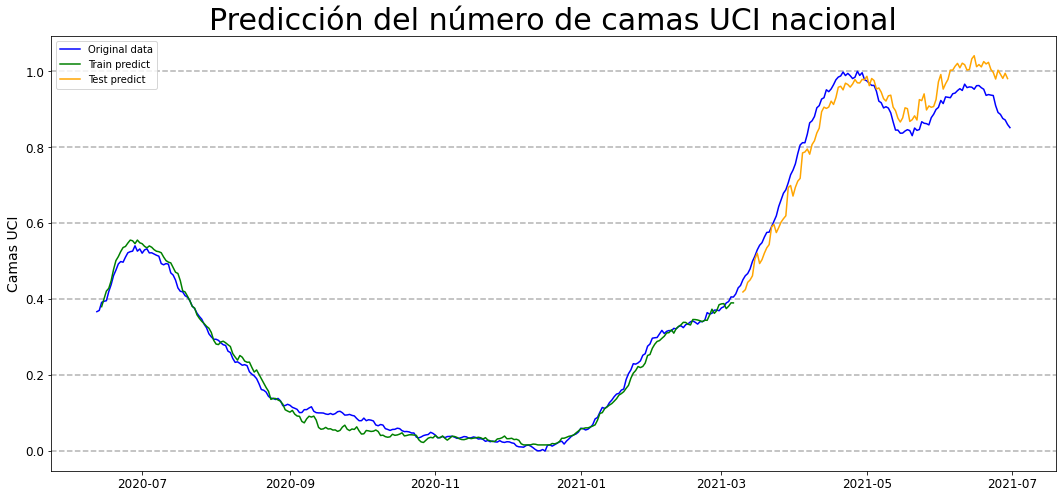

In [85]:
# Plot original data and predictions
fig, ax = plt.subplots(figsize=(18,8)) # Tamaño del gráfico
plt.plot(X[[y_lab]], color="blue", label="Original data")

#Título del gráfico
ax.set_title('Predicción del número de camas UCI nacional', fontsize=30)

# Define del eje y
ax.set_ylabel('Camas UCI')
plt.grid(True, 'major', 'y', ls='--', lw=1.5, c='k', alpha=.3)

#Define el eje x
plt.tick_params(axis='x', which='major', labelsize=12)

#plt.axis([0, 155,0,650])

plt.plot(trainPredictPlot, color="green", label="Train predict")
plt.plot(testPredictPlot, color="orange", label="Test predict")
ax.legend(loc="upper left", title="")


plt.show()

# LSTM

### Parameter Tuning

In [86]:
def tune_LSTM_NN(x_train, x_test, y_train, y_test,lags=[2,3,4],
                       layer1=[4,5,6], layer2=[2,3,4],layer3=None, 
                       epochs=50, activation=['tanh'], optimizer=['adam'], batches=1, verbose=True):
    a = [lags, layer1, layer2, activation, optimizer]
    comb_n = len(list(itertools.product(*a)))
    performances = np.zeros((comb_n,5))
    combinations = np.empty((comb_n,6), dtype='<U32')
    i = 0
    np.seterr(divide='ignore', invalid='ignore')
    for comb in itertools.product(*a):
        lag = comb[0]
        layer1 = comb[1]
        layer2 = comb[2]
        activation = comb[3]
        optimizer = comb[4]
        combinations[i, :] = np.array([i, lag, layer1, layer2, activation, optimizer])
        if verbose:
            print("Testing combination " + str(i) + ": " + str(comb))
        else:
            print("Progress: " + str(i) + "/" + str(comb_n))
    
        # Add lags in dataset
        train_x, test_x, train_y, test_y = lags_preparation(x_train, x_test, y_train, y_test, lag)
        
        # reshape input to be [samples, time steps, features !=columnas]
        features = round(train_x.shape[1]/(lag-1))
        train_x_temp = np.reshape(train_x.values, (train_x.shape[0], features, lag-1))
        test_x_temp = np.reshape(test_x.values, (test_x.shape[0], features, lag-1))
        
        # Create and fit LSTM model
        look_forward = 1
        model = Sequential()
        model.add(LSTM(layer1, batch_input_shape=(batches, features, lag-1), activation=activation, stateful=True, return_sequences=True))
        model.add(LSTM(layer2, batch_input_shape=(batches, features, lag-1), activation=activation, stateful=True))
        model.add(Dense(look_forward))
        model.compile(loss='mean_squared_error', optimizer=optimizer)
        for j in range(epochs):
            model.fit(train_x_temp, train_y.values, epochs=1, batch_size=batches, verbose=0, shuffle=False)
            model.reset_states()
                     
        # Generate predictions for training
        trainPredict = model.predict(train_x_temp, batch_size=batches)
        model.reset_states()
        testPredict = model.predict(test_x_temp, batch_size=batches)
        
        # Estimate model performance
        #trainScore = sqrt(mean_squared_error(train_y.values[:,0], trainPredict[:,0]))
        #testScore = sqrt(mean_squared_error(test_y.values[:,0], testPredict[:,0]))
        trainScore = model.evaluate(train_x_temp, train_y.values, batch_size=batches,verbose=0)
        testScore = model.evaluate(test_x_temp, test_y.values, batch_size=batches, verbose=0)
        
        # Calculate train correlation
        train_corr = np.corrcoef(train_y.values[:,0], trainPredict[:,0])
        train_corr = train_corr[0,1]
        
        # Calculate test correlation
        test_corr = np.corrcoef(test_y.values[:,0], testPredict[:,0])
        test_corr = test_corr[0,1]
        
        performances[i,:] = np.array([i, trainScore, train_corr, testScore, test_corr])
        if verbose:
            print("Performances: " + str(performances[i,:]))
        i = i+1
        
    np.seterr(divide='warn', invalid='warn')    
    
    performances_sorted = performances[np.argsort(performances[:, 3])]
    performances_df = pd.DataFrame(performances_sorted, columns=['id','Train RMSE','Train correlation', 'Test RMSE','Test correlation'])
    
    ordered_index = [int(x) for x in performances_sorted[:,0]]
    performances_df.index = ordered_index
    performances_df.drop('id', axis=1,inplace=True)
    
    combinations_sorted = combinations[ordered_index]
    combinations_df = pd.DataFrame(combinations_sorted, columns=['id','Lags', 'Nodes layer 1', 'Nodes layer 2', 'Activation Function', 'Optimizer Function'])
    combinations_df.index = ordered_index
    combinations_df.drop('id', axis=1,inplace=True)
    
    return(combinations_df, performances_df)

In [87]:
import itertools

# Tuning grid parameters

lags_range = [2,3,4,5]
layer1_range = [4, 6]#, 8, 10, 12]
layer2_range = [4, 6]#, 8, 10, 12]
layer3_range = []
activations = ['tanh']
optimizers = ['adam']
tuning_epochs=5
batch=1

In [88]:
# Number of combinations
i = 0
combs = [lags_range, layer1_range, layer2_range, activations, optimizers]
for comb in itertools.product(*combs):
    #print(np.array(comb).shape)
    i = i+1
print(str(i*tuning_epochs) + " combinaciones")

80 combinaciones


In [89]:
x_train.shape

(269, 9)

In [90]:
parameters_LSTM, performances_LSTM = tune_LSTM_NN(x_train, x_test, y_train, y_test, lags=lags_range, 
                   layer1=layer1_range, layer2=layer2_range, 
                   epochs=tuning_epochs, activation=activations, optimizer=optimizers, batches=batch, verbose=True)

Testing combination 0: (2, 4, 4, 'tanh', 'adam')
Performances: [0.         0.02664402 0.80118243 0.33885917 0.81664161]
Testing combination 1: (2, 4, 6, 'tanh', 'adam')
Performances: [1.         0.02677522 0.78528059 0.39371389 0.83547004]
Testing combination 2: (2, 6, 4, 'tanh', 'adam')
Performances: [2.         0.02556753 0.77464286 0.43440443 0.76298724]
Testing combination 3: (2, 6, 6, 'tanh', 'adam')
Performances: [3.         0.0537676  0.63879065 0.24621893 0.70377479]
Testing combination 4: (3, 4, 4, 'tanh', 'adam')
Performances: [4.         0.02598054 0.83953708 0.34088203 0.75394821]
Testing combination 5: (3, 4, 6, 'tanh', 'adam')
Performances: [5.         0.02224444 0.85350581 0.39447176 0.83226811]
Testing combination 6: (3, 6, 4, 'tanh', 'adam')
Performances: [6.         0.03503148 0.72674872 0.32294282 0.55995616]
Testing combination 7: (3, 6, 6, 'tanh', 'adam')
Performances: [7.         0.03252686 0.80648261 0.30429924 0.83537137]
Testing combination 8: (4, 4, 4, 'tanh',

In [91]:
performances_LSTM

,Train RMSE,Train correlation,Test RMSE,Test correlation
3,0.053768,0.638791,0.246219,0.703775
7,0.032527,0.806483,0.304299,0.835371
9,0.030093,0.853594,0.310919,0.822315
10,0.046933,-0.354966,0.310988,-0.671660
15,0.030482,0.925254,0.316072,0.700789
6,0.035031,0.726749,0.322943,0.559956
0,0.026644,0.801182,0.338859,0.816642
4,0.025981,0.839537,0.340882,0.753948
14,0.027383,0.906572,0.342157,0.780286
13,0.028692,0.882038,0.342632,0.482255


In [92]:
best_performance = performances_LSTM.iloc[0,:]
best_performance

Train RMSE           0.053768
Train correlation    0.638791
Test RMSE            0.246219
Test correlation     0.703775
Name: 3, dtype: float64

In [93]:
best_model = parameters_LSTM.iloc[0,:]
best_model

Lags                      2
Nodes layer 1             6
Nodes layer 2             6
Activation Function    tanh
Optimizer Function     adam
Name: 3, dtype: object

### Tuned LSTM results

In [94]:
look_back = int(best_model['Lags'])
epochs=100

train_x, test_x, train_y, test_y = lags_preparation(x_train, x_test, y_train, y_test, look_back)

In [95]:
features = round(train_x.shape[1]/(look_back-1))
x_train_temp = np.reshape(train_x.values, (train_x.shape[0], features, look_back-1))
x_test_temp = np.reshape(test_x.values, (test_x.shape[0], features, look_back-1))

In [96]:
# create and fit the LSTM network
batch_size = batch
look_forward = 1
model = Sequential()
model.add(LSTM(int(best_model['Nodes layer 1']), activation=best_model['Activation Function'], batch_input_shape=(batch_size, features, look_back-1), stateful=True, return_sequences=True))
model.add(LSTM(int(best_model['Nodes layer 2']), activation=best_model['Activation Function'], batch_input_shape=(batch_size, features, look_back-1), stateful=True))
model.add(Dense(look_forward))
model.compile(loss='mean_squared_error', optimizer=best_model['Optimizer Function'])

In [97]:
model.summary()

Model: "sequential_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_32 (LSTM)               (1, 9, 6)                 192       
_________________________________________________________________
lstm_33 (LSTM)               (1, 6)                    312       
_________________________________________________________________
dense_67 (Dense)             (1, 1)                    7         
Total params: 511
Trainable params: 511
Non-trainable params: 0
_________________________________________________________________


In [98]:
for i in range(epochs):
    model.fit(x_train_temp, train_y.values, epochs=1, batch_size=batch_size, verbose=2, shuffle=False)
    model.reset_states()

266/266 - 1s - loss: 0.0127
266/266 - 1s - loss: 0.0044
266/266 - 1s - loss: 0.0056
266/266 - 1s - loss: 0.0068
266/266 - 1s - loss: 0.0090
266/266 - 1s - loss: 0.0131
266/266 - 1s - loss: 0.0157
266/266 - 1s - loss: 0.0184
266/266 - 1s - loss: 0.0204
266/266 - 1s - loss: 0.0215
266/266 - 1s - loss: 0.0196
266/266 - 1s - loss: 0.0187
266/266 - 1s - loss: 0.0180
266/266 - 1s - loss: 0.0156
266/266 - 1s - loss: 0.0128
266/266 - 1s - loss: 0.0099
266/266 - 1s - loss: 0.0066
266/266 - 1s - loss: 0.0030
266/266 - 1s - loss: 0.0019
266/266 - 1s - loss: 0.0018
266/266 - 1s - loss: 0.0016
266/266 - 1s - loss: 0.0014
266/266 - 1s - loss: 0.0013
266/266 - 1s - loss: 0.0012
266/266 - 1s - loss: 0.0011
266/266 - 1s - loss: 0.0010
266/266 - 1s - loss: 9.5532e-04
266/266 - 1s - loss: 8.5765e-04
266/266 - 1s - loss: 7.4203e-04
266/266 - 1s - loss: 6.0544e-04
266/266 - 1s - loss: 4.6022e-04
266/266 - 1s - loss: 3.3635e-04
266/266 - 1s - loss: 2.5136e-04
266/266 - 1s - loss: 1.9593e-04
266/266 - 1s - l

In [99]:
# make predictions
trainPredict = model.predict(x_train_temp, batch_size=batch_size)
model.reset_states()
testPredict = model.predict(x_test_temp, batch_size=batch_size)
# invert predictions
#trainPredict = scaler.inverse_transform(trainPredict)
#y_train = scaler.inverse_transform([y_train])
#testPredict = scaler.inverse_transform(testPredict)
#y_test = scaler.inverse_transform([y_test])
# calculate root mean squared error
trainScore = sqrt(mean_squared_error(train_y.values, trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = sqrt(mean_squared_error(test_y.values, testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 0.04 RMSE
Test Score: 0.32 RMSE


In [100]:
#trainPredict_temp = trainPredict
#testPredict_temp = testPredict

In [101]:
trainPredict = trainPredict[:,0]
testPredict = testPredict[:,0]

In [102]:
testPredict.shape

(112,)

In [103]:
from copy import deepcopy
# Create datasets for plotting
Y = X[[y_lab]]
base = np.empty_like(Y)
base[:] = np.nan

In [104]:
# Create reference data
referencePlot = deepcopy(base[:])
referencePlot[:len(X),:] = X[[y_lab]]
referencePlot = pd.DataFrame(referencePlot, columns=['Reference values'], index=Y.index)

In [105]:
# Create train predict data
trainPredictPlot = deepcopy(base[:])
trainPredictPlot[look_back:len(trainPredict)+look_back,0] = trainPredict[:]
trainPredictPlot = pd.DataFrame(trainPredictPlot, columns=['Predicted Training'], index=Y.index)

In [106]:
# Create test predict data
testPredictPlot = deepcopy(base[:])
testPredictPlot[len(trainPredict)+(look_back*2)+2:,0] = testPredict[:]
testPredictPlot = pd.DataFrame(testPredictPlot, columns=['Predicted Testing'], index=Y.index)

In [107]:
plotData = pd.merge(referencePlot, trainPredictPlot, how='outer', left_index=True, right_index=True)
plotData = pd.merge(plotData, testPredictPlot, how='outer', left_index=True, right_index=True)

In [108]:
plotData

,Reference values,Predicted Training,Predicted Testing
2020-06-12,0.367039,NaN,NaN
2020-06-13,0.370277,NaN,NaN
2020-06-14,0.391508,0.384362,NaN
2020-06-15,0.394386,0.415474,NaN
2020-06-16,0.395826,0.446421,NaN
2020-06-17,0.419935,0.399940,NaN
2020-06-18,0.438287,0.432444,NaN
2020-06-19,0.462037,0.473076,NaN
2020-06-20,0.476430,0.495031,NaN
2020-06-21,0.492623,0.525984,NaN


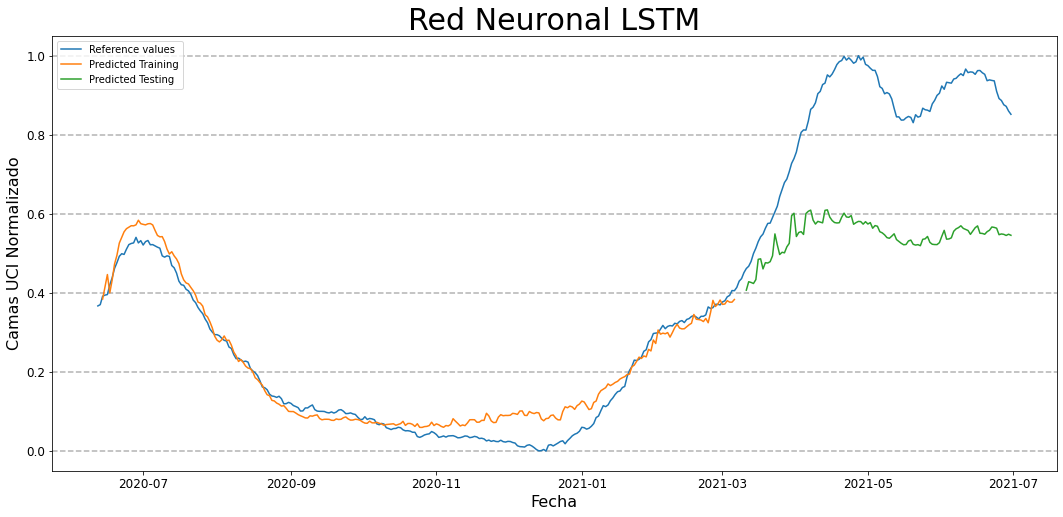

In [109]:
 fig = plt.figure(figsize=(18,8))
ax = fig.add_subplot(111)
ax.plot(plotData)
#Título del gráfico
plt.title('Red Neuronal LSTM', fontsize=30)
plt.xlabel("Fecha", fontsize=16)
plt.ylabel("Camas UCI Normalizado", fontsize=16)
ax.grid(True, 'major', 'y', ls='--', lw=1.5, c='k', alpha=.3)
ax.legend(plotData.columns,loc='upper left')
plt.show()

# Predicción camas UCI para las próximas 2 semanas
**Hasta aquí es la ultima entrega (resultados modelo) **

In [114]:
look_back = 2
epochs=100

train_x, test_x, train_y, test_y = lags_preparation(x_train, x_test, y_train, y_test, look_back)

In [115]:
# create and fit the LSTM network
batch_size = 1
look_forward = 14
model = Sequential()
model.add(LSTM(4, batch_input_shape=(batch_size, features, look_back-1), stateful=True, return_sequences=True))
model.add(LSTM(4, batch_input_shape=(batch_size, features, look_back-1), stateful=True))
model.add(Dense(look_forward))
model.compile(loss='mean_squared_error', optimizer='adam')

In [116]:
model.summary()

Model: "sequential_35"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_36 (LSTM)               (1, 9, 4)                 96        
_________________________________________________________________
lstm_37 (LSTM)               (1, 4)                    144       
_________________________________________________________________
dense_69 (Dense)             (1, 14)                   70        
Total params: 310
Trainable params: 310
Non-trainable params: 0
_________________________________________________________________


In [117]:
y_train_temp = train_y
y_test_temp = test_y

In [118]:
for i in range(epochs):
    model.fit(x_train_temp, y_train_temp.values, epochs=1, batch_size=batch_size, verbose=2, shuffle=False)
    model.reset_states()

266/266 - 1s - loss: 0.0503
266/266 - 1s - loss: 0.0243
266/266 - 1s - loss: 0.0215
266/266 - 1s - loss: 0.0256
266/266 - 1s - loss: 0.0260
266/266 - 1s - loss: 0.0256
266/266 - 1s - loss: 0.0248
266/266 - 1s - loss: 0.0242
266/266 - 1s - loss: 0.0239
266/266 - 1s - loss: 0.0227
266/266 - 1s - loss: 0.0200
266/266 - 1s - loss: 0.0150
266/266 - 1s - loss: 0.0096
266/266 - 1s - loss: 0.0053
266/266 - 1s - loss: 0.0029
266/266 - 1s - loss: 0.0018
266/266 - 1s - loss: 0.0012
266/266 - 1s - loss: 7.5789e-04
266/266 - 1s - loss: 5.8551e-04
266/266 - 1s - loss: 4.8899e-04
266/266 - 1s - loss: 4.0292e-04
266/266 - 1s - loss: 3.2368e-04
266/266 - 1s - loss: 2.5680e-04
266/266 - 1s - loss: 2.0371e-04
266/266 - 1s - loss: 1.6327e-04
266/266 - 1s - loss: 1.3364e-04
266/266 - 1s - loss: 1.1298e-04
266/266 - 1s - loss: 9.9700e-05
266/266 - 1s - loss: 9.2469e-05
266/266 - 1s - loss: 9.0296e-05
266/266 - 1s - loss: 9.2557e-05
266/266 - 1s - loss: 9.8959e-05
266/266 - 1s - loss: 1.0943e-04
266/266 - 1s

In [119]:
# make predictions
trainPredict = model.predict(x_train_temp, batch_size=batch_size)
model.reset_states()
testPredict = model.predict(x_test_temp, batch_size=batch_size)
# invert predictions
#trainPredict = scaler.inverse_transform(trainPredict)
#y_train = scaler.inverse_transform([y_train])
#testPredict = scaler.inverse_transform(testPredict)
#y_test = scaler.inverse_transform([y_test])
# calculate root mean squared error
trainScore = sqrt(mean_squared_error(y_train_temp.values[:,0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = sqrt(mean_squared_error(y_test_temp.values[:,0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 0.02 RMSE
Test Score: 0.37 RMSE


In [120]:
model.summary()

Model: "sequential_35"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_36 (LSTM)               (1, 9, 4)                 96        
_________________________________________________________________
lstm_37 (LSTM)               (1, 4)                    144       
_________________________________________________________________
dense_69 (Dense)             (1, 14)                   70        
Total params: 310
Trainable params: 310
Non-trainable params: 0
_________________________________________________________________


In [121]:
#trainPredict_temp = trainPredict
#testPredict_temp = testPredict

In [122]:
trainPredict = trainPredict[:,0]

In [123]:
testPredict.shape

(112, 14)

In [124]:
#today = testPredict.shape[0]
testPredictActual = testPredict[:,0]
testPredictFuture = testPredict[-1,0:]


In [125]:
testPredictFuture.shape

(14,)

In [126]:
from datetime import datetime

Y = X[[y_lab]]
last_date = data.index[-1]
predicted_dates = pd.date_range(start = last_date, periods = 14).to_pydatetime().tolist()
Y = Y.reindex(Y.index.union(predicted_dates))
#new_len = len(trainPredict) + len(predicted_dates)

In [127]:
# Create datasets for plotting
base = np.empty_like(Y)
base[:] = np.nan

In [128]:
# Create reference data
referencePlot = deepcopy(base[:])
referencePlot[:len(X),:] = X[[y_lab]]
referencePlot = pd.DataFrame(referencePlot, columns=['Reference values'], index=Y.index)

In [129]:
# Create train predict data
trainPredictPlot = deepcopy(base[:])
trainPredictPlot[look_back:len(trainPredict)+look_back,0] = trainPredict[:]
trainPredictPlot = pd.DataFrame(trainPredictPlot, columns=['Predicted Training'], index=Y.index)

In [130]:
# Create test predict data
testPredictPlot = deepcopy(base[:])
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(base)-len(testPredictFuture),0] = testPredictActual[:]
testPredictPlot = pd.DataFrame(testPredictPlot, columns=['Predicted Testing'], index=Y.index)

In [131]:
# Create predicted data
predictedFuturePlot = deepcopy(base[:])
predictedFuturePlot[len(base)-len(testPredictFuture):,0] = testPredictFuture[:]
predictedFuturePlot = pd.DataFrame(predictedFuturePlot, columns=['Predicted Future'],index=Y.index)

In [132]:
plotData = pd.merge(referencePlot, trainPredictPlot, how='outer', left_index=True, right_index=True)
plotData = pd.merge(plotData, testPredictPlot, how='outer', left_index=True, right_index=True)
plotData = pd.merge(plotData, predictedFuturePlot, how='outer', left_index=True, right_index=True)

In [133]:
plotData

,Reference values,Predicted Training,Predicted Testing,Predicted Future
2020-06-12,0.367039,NaN,NaN,NaN
2020-06-13,0.370277,NaN,NaN,NaN
2020-06-14,0.391508,0.364640,NaN,NaN
2020-06-15,0.394386,0.371413,NaN,NaN
2020-06-16,0.395826,0.386060,NaN,NaN
2020-06-17,0.419935,0.374736,NaN,NaN
2020-06-18,0.438287,0.383208,NaN,NaN
2020-06-19,0.462037,0.402772,NaN,NaN
2020-06-20,0.476430,0.414974,NaN,NaN
2020-06-21,0.492623,0.430990,NaN,NaN


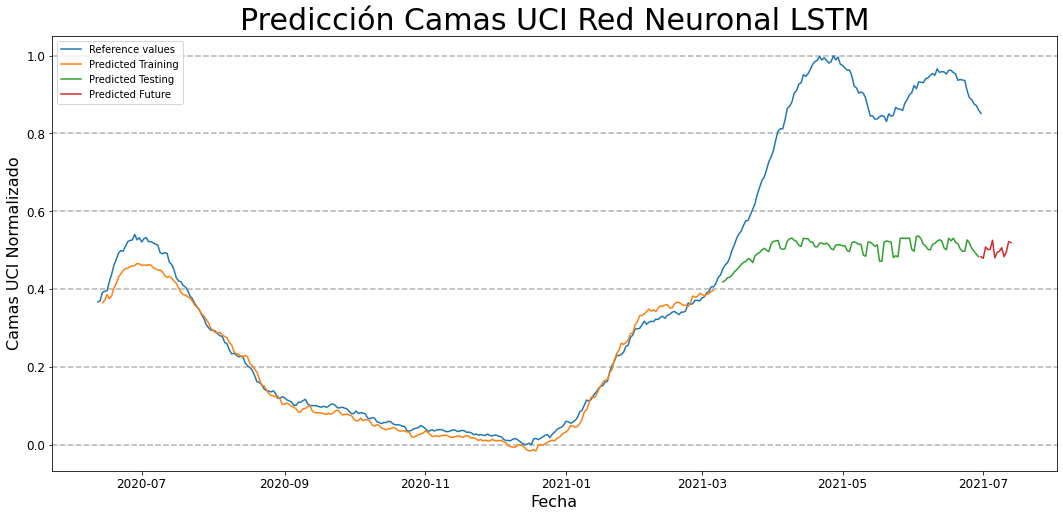

In [134]:
 fig = plt.figure(figsize=(18,8))
ax = fig.add_subplot(111)
ax.plot(plotData)
#Título del gráfico
plt.title('Predicción Camas UCI Red Neuronal LSTM', fontsize=30)
plt.xlabel("Fecha", fontsize=16)
plt.ylabel("Camas UCI Normalizado", fontsize=16)
ax.grid(True, 'major', 'y', ls='--', lw=1.5, c='k', alpha=.3)
ax.legend(plotData.columns,loc='upper left')
plt.show()